# Classificação de Sinais de Qualidade de Energia com CNN 1D

Rede neural convolucional 1D para classificar 16 tipos de distúrbios elétricos.

## 1. Importar Bibliotecas

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponível: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU disponível: []


## 2. Carregar Dataset

In [2]:
# Carregar dataset
with open('dataset/complete_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

X = dataset['signals']
y = dataset['labels']
class_names = dataset['class_names']

print(f"Dataset carregado:")
print(f"  Shape dos sinais: {X.shape}")
print(f"  Shape dos labels: {y.shape}")
print(f"  Número de classes: {len(class_names)}")

Dataset carregado:
  Shape dos sinais: (22500, 1536)
  Shape dos labels: (22500,)
  Número de classes: 9


## 3. Preparar Dados (70% Treino, 15% Validação, 15% Teste)

In [3]:
# Dividir em treino (70%) e temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Dividir temp em validação (15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Divisão dos dados:")
print(f"  Treino:     {X_train.shape[0]} amostras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validação:  {X_val.shape[0]} amostras ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Teste:      {X_test.shape[0]} amostras ({X_test.shape[0]/len(X)*100:.1f}%)")

Divisão dos dados:
  Treino:     15750 amostras (70.0%)
  Validação:  3375 amostras (15.0%)
  Teste:      3375 amostras (15.0%)


In [4]:
# Normalizar dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Reshape para CNN 1D: (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"\nShape após reshape:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")


Shape após reshape:
  X_train: (15750, 1536, 1)
  X_val:   (3375, 1536, 1)
  X_test:  (3375, 1536, 1)


## 4. Construir Modelo CNN 1D

In [5]:
def build_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        # Bloco 1
        layers.Conv1D(64, kernel_size=7, activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),

        # Bloco 2
        layers.Conv1D(128, kernel_size=5, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),

        # Bloco 3 (reduzido)
        layers.Conv1D(256, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.4),

        # Camadas densas
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


# Criar modelo
model = build_cnn_model(input_shape=(X_train.shape[1], 1), num_classes=len(class_names))

# Compilar
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\marce\Desktop\Master Thesis Code\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1536, 64)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 768, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 768, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 768, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 384, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 384, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 384, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 384, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 192, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 192, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,291,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,434,697 (24.55 MB)

 Trainable params: 6,433,801 (24.54 MB)

 Non-trainable params: 896 (3.50 KB)

## 5. Treinar Modelo (25 Épocas)

In [6]:
import psutil
import threading
import time
import matplotlib.pyplot as plt
import numpy as np
import locale

# Configura locale para usar vírgula como separador decimal
try:
    locale.setlocale(locale.LC_NUMERIC, 'pt_BR.UTF-8')
except:
    try:
        locale.setlocale(locale.LC_NUMERIC, 'Portuguese_Brazil.1252')
    except:
        print("⚠️ Aviso: Não foi possível configurar locale pt_BR")

plt.rcParams['axes.formatter.use_locale'] = True

class MemoryMonitor:
    def __init__(self):
        self.memory_usage = []
        self.timestamps = []
        self.monitoring = False
        self.start_time = None
        self.thread = None
        self.mean_memory = None
        
    def _monitor(self):
        """Função que roda em thread separada para monitorar memória"""
        while self.monitoring:
            # Pega uso de memória em MB
            memory_mb = psutil.Process().memory_info().rss / 1024 / 1024
            current_time = time.time() - self.start_time
            
            self.memory_usage.append(memory_mb)
            self.timestamps.append(current_time)
            
            time.sleep(0.5)  # Atualiza a cada 0.5 segundos
    
    def start(self):
        """Inicia o monitoramento"""
        self.monitoring = True
        self.start_time = time.time()
        self.thread = threading.Thread(target=self._monitor, daemon=True)
        self.thread.start()
        print(f"📊 Monitoramento de memória iniciado...")
    
    def stop(self):
        """Para o monitoramento"""
        self.monitoring = False
        if self.thread:
            self.thread.join()
        self.mean_memory = np.mean(self.memory_usage)
        print(f"✅ Monitoramento finalizado!")

        # Print das estatísticas
        print("\n" + "="*50)
        print("📊 RELATÓRIO DE USO DE MEMÓRIA")
        print("="*50)
        print(f"⏱️  Tempo total de treinamento: {self.timestamps[-1]:.2f} segundos")
        print(f"📉 Memória mínima: {np.min(self.memory_usage):.2f} MB")
        print(f"📊 Memória média: {self.mean_memory:.2f} MB")
        print(f"📈 Memória máxima (pico): {np.max(self.memory_usage):.2f} MB")
        print(f"💾 Total consumido: {np.max(self.memory_usage):.2f} MB")
        print(f"📏 Variação: {np.max(self.memory_usage) - np.min(self.memory_usage):.2f} MB")
        print("="*50 + "\n")

In [7]:
monitor = MemoryMonitor()

monitor.start()

# Treinar
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    verbose=1
)
        
monitor.stop()

📊 Monitoramento de memória iniciado...


Epoch 1/25
493/493 ━━━━━━━━━━━━━━━━━━━━ 106s 212ms/step - accuracy: 0.7737 - loss: 0.9847 - val_accuracy: 0.5763 - val_loss: 10.5431
Epoch 2/25
493/493 ━━━━━━━━━━━━━━━━━━━━ 111s 225ms/step - accuracy: 0.8331 - loss: 0.3938 - val_accuracy: 0.8299 - val_loss: 0.3180
Epoch 3/25
493/493 ━━━━━━━━━━━━━━━━━━━━ 96s 194ms/step - accuracy: 0.8395 - loss: 0.3616 - val_accuracy: 0.8874 - val_loss: 0.2279
Epoch 4/25
493/493 ━━━━━━━━━━━━━━━━━━━━ 99s 200ms/step - accuracy: 0.8554 - loss: 0.2989 - val_accuracy: 0.8859 - val_loss: 0.2427
Epoch 5/25
493/493 ━━━━━━━━━━━━━━━━━━━━ 95s 192ms/step - accuracy: 0.8692 - loss: 0.2877 - val_accuracy: 0.8898 - val_loss: 0.2595
Epoch 6/25
493/493 ━━━━━━━━━━━━━━━━━━━━ 93s 190ms/step - accuracy: 0.8752 - loss: 0.2805 - val_accuracy: 0.9022 - val_loss: 0.2413
Epoch 7/25
493/493 ━━━━━━━━━━━━━━━━━━━━ 94s 191ms/step - accuracy: 0.8847 - loss: 0.2649 - val_accuracy: 0.9247 - val_loss: 0.2000
Epoch 8/25
493/493 ━━━━━━━━━━━━━━━━━━━━ 96s 195ms/step - accuracy: 0.9278 - loss

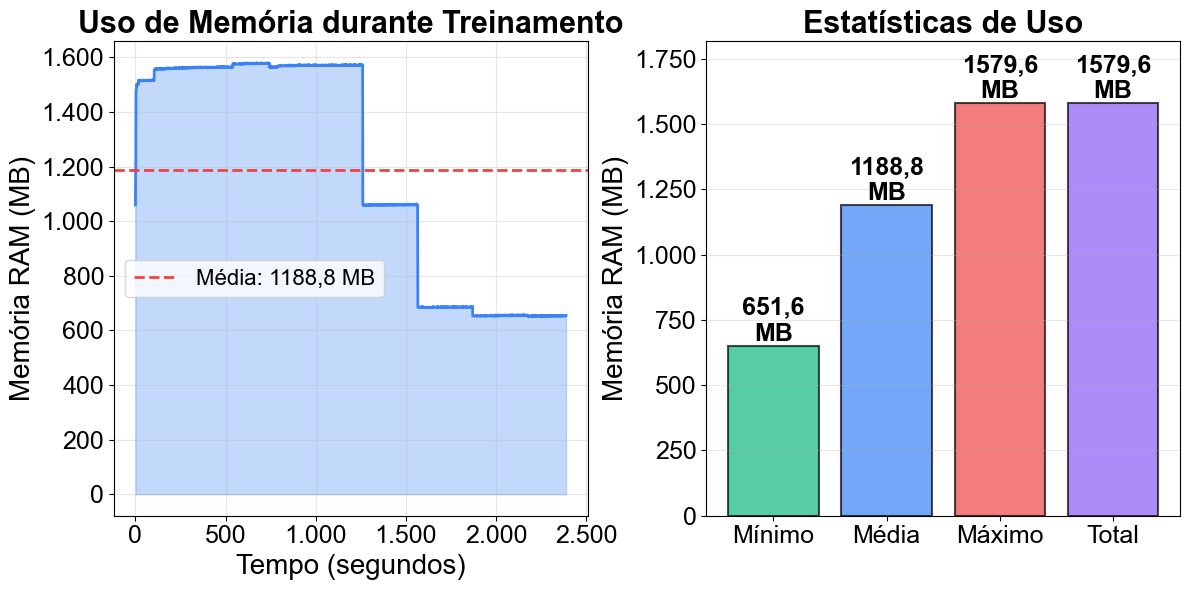

In [8]:
# Configura fonte globalmente para esta figura
plt.rcParams['font.family'] = 'Arial'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico 1: Evolução temporal
ax1.plot(monitor.timestamps, monitor.memory_usage, linewidth=2, color='#3b82f6')
ax1.fill_between(monitor.timestamps, monitor.memory_usage, alpha=0.3, color='#3b82f6')
ax1.set_xlabel('Tempo (segundos)', fontsize=20, family='Arial')
ax1.set_ylabel('Memória RAM (MB)', fontsize=20, family='Arial')
ax1.set_title('Uso de Memória durante Treinamento', fontsize=22, fontweight='bold', family='Arial')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', labelsize=18)

# Adiciona linha de média
mean_memory = np.mean(monitor.memory_usage)
ax1.axhline(y=mean_memory, color='#ef4444', linestyle='--', 
            label=f'Média: {mean_memory:.1f} MB'.replace('.', ','), linewidth=2)
ax1.legend(prop={'family': 'Arial', 'size': 16})

# Gráfico 2: Estatísticas
stats = {
    'Mínimo': np.min(monitor.memory_usage),
    'Média': mean_memory,
    'Máximo': np.max(monitor.memory_usage),
    'Total': np.max(monitor.memory_usage)
}

colors = ['#10b981', '#3b82f6', '#ef4444', '#8b5cf6']
bars = ax2.bar(stats.keys(), stats.values(), color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Adiciona valores em cima das barras (com vírgula como separador decimal)
for bar, value in zip(bars, stats.values()):
    height = bar.get_height()
    valor_formatado = f'{value:.1f}'.replace('.', ',')  # <<< AQUI
    ax2.text(
        bar.get_x() + bar.get_width() / 2., height,
        f'{valor_formatado}\nMB',
        ha='center', va='bottom', fontsize=18, fontweight='bold', family='Arial'
    )

ax2.set_ylabel('Memória RAM (MB)', fontsize=20, family='Arial')
ax2.set_title('Estatísticas de Uso', fontsize=22, fontweight='bold', family='Arial')
ax2.grid(True, axis='y', alpha=0.3)
ax2.tick_params(axis='both', labelsize=18)

# Ajusta limites do eixo Y para dar espaço aos rótulos
max_val = max(stats.values())
ax2.set_ylim(0, max_val * 1.15)  # 15% de margem no topo

plt.tight_layout()
plt.savefig('resultados/centralizado_consumo_memoria.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Gráficos de Convergência

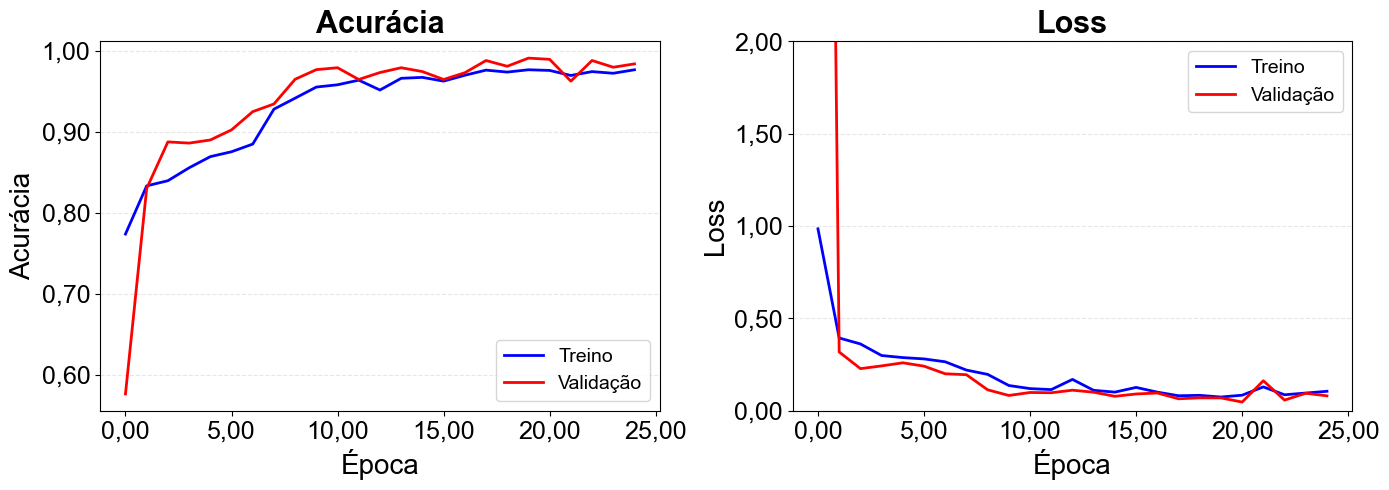

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# --------------------------
# Função para trocar . por ,
# --------------------------
def virgula(x, pos):
    """Formata ticks usando vírgula como separador decimal."""
    s = f'{x:.2f}'
    return s.replace('.', ',')

formatter = FuncFormatter(virgula)

# Definir fonte Arial
plt.rcParams['font.family'] = 'Arial'

# Plotar acurácia e loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ------------------------------------------------------
# Acurácia
# ------------------------------------------------------
ax1.plot(history.history['accuracy'], 'b-', linewidth=2, label='Treino')
ax1.plot(history.history['val_accuracy'], 'r-', linewidth=2, label='Validação')
ax1.set_xlabel('Época', fontsize=20)
ax1.set_ylabel('Acurácia', fontsize=20)
ax1.set_title('Acurácia', fontsize=22, fontweight='bold')
ax1.legend(fontsize=14, loc='lower right')
ax1.grid(True, axis='y', alpha=0.3, linestyle='--')
ax1.tick_params(axis='both', labelsize=18)
ax1.yaxis.set_major_formatter(formatter)   # <<< AQUI
ax1.xaxis.set_major_formatter(formatter)   # <<< AQUI (opcional)

# ------------------------------------------------------
# Loss
# ------------------------------------------------------
ax2.plot(history.history['loss'], 'b-', linewidth=2, label='Treino')
ax2.plot(history.history['val_loss'], 'r-', linewidth=2, label='Validação')
ax2.set_xlabel('Época', fontsize=20)
ax2.set_ylabel('Loss', fontsize=20)
ax2.set_title('Loss', fontsize=22, fontweight='bold')
ax2.legend(fontsize=14)
ax2.grid(True, axis='y', alpha=0.3, linestyle='--')
ax2.tick_params(axis='both', labelsize=18)
ax2.yaxis.set_major_formatter(formatter)   # <<< AQUI
ax2.xaxis.set_major_formatter(formatter)   # <<< AQUI (opcional)
ax2.set_ylim(0, 2)

plt.tight_layout()
plt.savefig('resultados/centralizado_convergencia.png', dpi=150, bbox_inches='tight')
plt.show()


## 7. Avaliar no Conjunto de Teste

In [10]:
# Avaliar no teste
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"\n{'='*50}")
print(f"RESULTADOS NO CONJUNTO DE TESTE")
print(f"{'='*50}")
print(f"  Acurácia: {test_accuracy*100:.2f}%")
print(f"  Loss:     {test_loss:.4f}")
print(f"{'='*50}")


RESULTADOS NO CONJUNTO DE TESTE
  Acurácia: 98.04%
  Loss:     0.0695


## 8. Matriz de Confusão

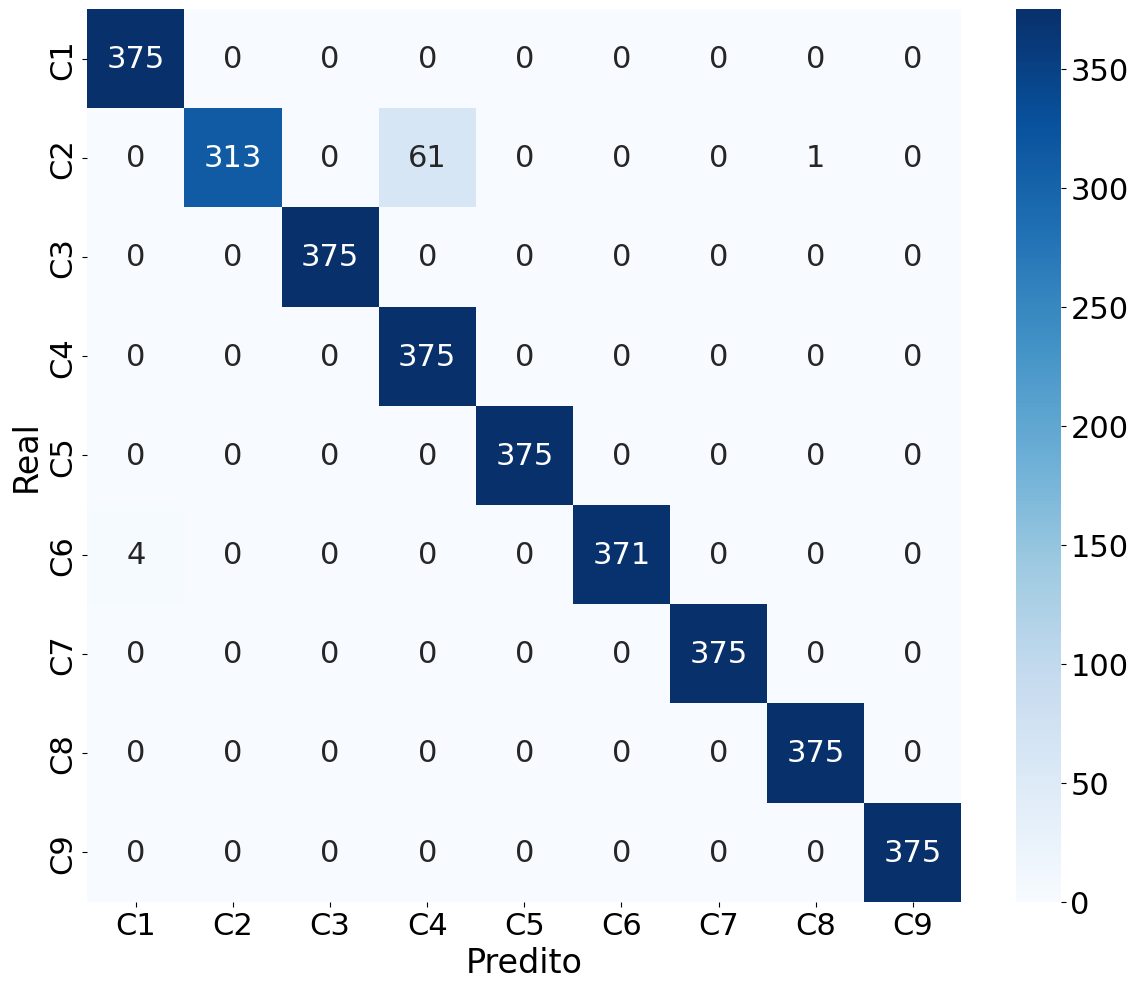

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

plt.rcdefaults()
sns.reset_defaults()

# Predições
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(12, 10))

ax = sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=[f'C{i+1}' for i in range(len(class_names))],
    yticklabels=[f'C{i+1}' for i in range(len(class_names))],
    annot_kws={"size": 22}  # valores internos
)

# Ticks dos eixos X e Y
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

# Aumentar o eixo auxiliar (colorbar)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)

plt.xlabel('Predito', fontsize=24)
plt.ylabel('Real', fontsize=24)
#plt.title('Matriz de Confusão', fontsize=22, fontweight='bold')

plt.tight_layout()
plt.savefig('resultados/centralizado_matriz_confusao.png', dpi=150, bbox_inches='tight')
plt.show()


In [12]:
# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_classes, 
                           target_names=[f'C{i+1}' for i in range(len(class_names))]))


Relatório de Classificação:
              precision    recall  f1-score   support

          C1       0.99      1.00      0.99       375
          C2       1.00      0.83      0.91       375
          C3       1.00      1.00      1.00       375
          C4       0.86      1.00      0.92       375
          C5       1.00      1.00      1.00       375
          C6       1.00      0.99      0.99       375
          C7       1.00      1.00      1.00       375
          C8       1.00      1.00      1.00       375
          C9       1.00      1.00      1.00       375

    accuracy                           0.98      3375
   macro avg       0.98      0.98      0.98      3375
weighted avg       0.98      0.98      0.98      3375



## 9. Salvar Modelo

In [13]:
# Salvar modelo
model.save('dataset/cnn_model.h5')
print("Modelo salvo em: dataset/cnn_model.h5")

Modelo salvo em: dataset/cnn_model.h5


## 10. Resumo Final

In [14]:
print(f"\n{'='*50}")
print(f"RESUMO DO TREINAMENTO")
print(f"{'='*50}")
print(f"\nArquitetura: CNN 1D")
print(f"Épocas: 25")
print(f"Batch size: 32")
print(f"\nDivisão dos dados:")
print(f"  Treino:     70% ({X_train.shape[0]} amostras)")
print(f"  Validação:  15% ({X_val.shape[0]} amostras)")
print(f"  Teste:      15% ({X_test.shape[0]} amostras)")
print(f"\nResultados finais:")
print(f"  Acurácia de treino:    {history.history['accuracy'][-1]*100:.2f}%")
print(f"  Acurácia de validação: {history.history['val_accuracy'][-1]*100:.2f}%")
print(f"  Acurácia de teste:     {test_accuracy*100:.2f}%")
print(f"\nArquivos gerados:")
print(f"  • convergencia.png")
print(f"  • matriz_confusao.png")
print(f"  • cnn_model.h5")
print(f"\n{'='*50}")


RESUMO DO TREINAMENTO

Arquitetura: CNN 1D
Épocas: 25
Batch size: 32

Divisão dos dados:
  Treino:     70% (15750 amostras)
  Validação:  15% (3375 amostras)
  Teste:      15% (3375 amostras)

Resultados finais:
  Acurácia de treino:    97.64%
  Acurácia de validação: 98.37%
  Acurácia de teste:     98.04%

Arquivos gerados:
  • convergencia.png
  • matriz_confusao.png
  • cnn_model.h5



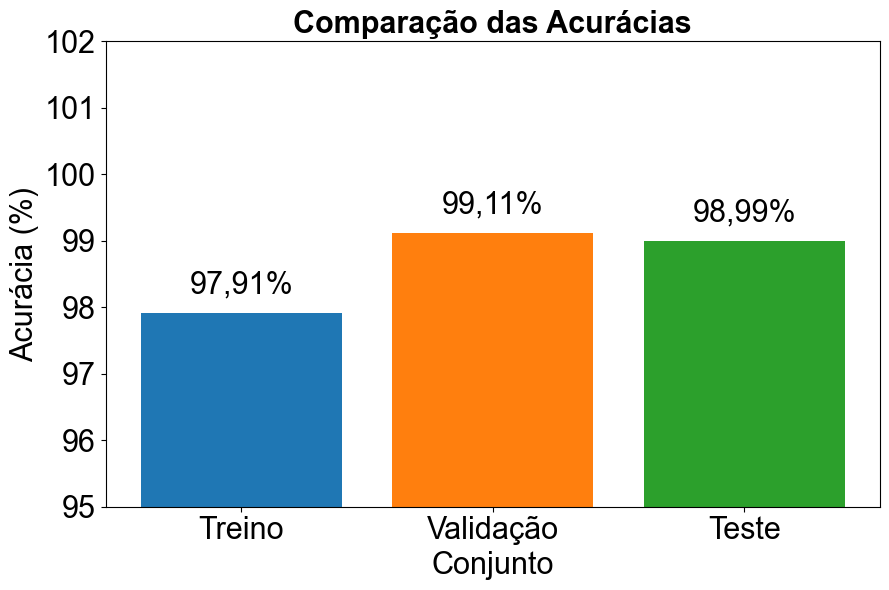

In [15]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# -------------------------------------------------------
# CONFIGURAÇÕES DE FONTE
# -------------------------------------------------------
rcParams['font.family'] = 'Arial'
title_size = 22
label_size = 22
tick_size = 22

# -------------------------------------------------------
# DADOS
# -------------------------------------------------------
labels = ['Treino', 'Validação', 'Teste']
values = [97.91, 99.11, 98.99]

# -------------------------------------------------------
# DEFINIR CORES PERSONALIZADAS
# -------------------------------------------------------
cores = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Azul, laranja, verde

# -------------------------------------------------------
# LIMPAR CONFIGURAÇÕES ANTERIORES
# -------------------------------------------------------
plt.close('all')
plt.rcdefaults()
rcParams['font.family'] = 'Arial'

# -------------------------------------------------------
# PLOT
# -------------------------------------------------------
plt.figure(figsize=(9, 6))

bars = plt.bar(labels, values, color=cores)

plt.ylabel('Acurácia (%)', fontsize=label_size)
plt.xlabel('Conjunto', fontsize=label_size)
plt.title('Comparação das Acurácias', fontsize=title_size, fontweight='bold')

plt.ylim(95, 102)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

# -------------------------------------------------------
# Mostrar valores acima das barras com vírgula
# -------------------------------------------------------
for bar in bars:
    height = bar.get_height()
    valor = f"{height:.2f}".replace('.', ',')  # Usa vírgula
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 0.3,
             valor + '%',
             ha='center',
             fontsize=tick_size)

plt.tight_layout()

# -------------------------------------------------------
# SALVAR
# -------------------------------------------------------
plt.savefig('resultados/centralizado_grafico_acuracias.png', dpi=150, bbox_inches='tight')
plt.show()


# 11. SHAP

In [16]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from sklearn.model_selection import train_test_split

# -------------------------
# CONFIG
# -------------------------
from matplotlib.ticker import FuncFormatter

def virgula(x, pos):
    """Formata ticks com vírgula como separador decimal."""
    s = f'{x:.2f}'
    return s.replace('.', ',')
    
formatter = FuncFormatter(virgula)


bg_size = 200
rng = np.random.default_rng(42)
output_dir = Path('shap')
output_dir.mkdir(exist_ok=True)

# -------------------------
# Carregar dataset ORIGINAL
# -------------------------
print("Carregando dataset original...")
with open('dataset/complete_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)
    class_names = dataset['class_names']

X = dataset['signals']
y = dataset['labels']

# Mesma divisão do treinamento
X_train_orig, X_temp, y_train_orig, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val_orig, X_test_orig, y_val_orig, y_test_orig = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Dados originais carregados: {len(X_test_orig)} amostras de teste")

# -------------------------
# Preparar background para SHAP
# -------------------------
n_train = X_train.shape[0]
bg_size = min(bg_size, n_train)
bg_idx = rng.choice(n_train, size=bg_size, replace=False)
background = X_train[bg_idx].astype(np.float32)

# -------------------------
# Criar explainer
# -------------------------
print("\nCriando SHAP explainer...")
explainer = shap.DeepExplainer(model, background)
print("Explainer criado com sucesso!")

# -------------------------
# Gerar SHAP para uma amostra de cada classe
# -------------------------
print(f"\nGerando explicações SHAP para {len(class_names)} classes...\n")

for class_idx, class_name in enumerate(class_names):
    print(f"Processando classe {class_idx+1}/{len(class_names)}: {class_name}")
    
    # Encontrar amostras desta classe no conjunto de teste
    class_test_indices = np.where(y_test_orig == class_idx)[0]
    
    if len(class_test_indices) == 0:
        print(f"  ⚠️  Nenhuma amostra encontrada para {class_name}")
        continue
    
    # Escolher primeira amostra desta classe
    sample_idx = class_test_indices[0]
    
    # Sinal original e normalizado
    signal_original = X_test_orig[sample_idx]
    signal_normalized = X_test[sample_idx:sample_idx+1].astype(np.float32)
    
    # Calcular SHAP values
    shap_values = explainer.shap_values(signal_normalized)
    
    # DEBUG: Verificar formato do SHAP
    if class_idx == 0:  # Printar apenas na primeira iteração
        print(f"\n  DEBUG - Formato SHAP:")
        print(f"    Tipo: {type(shap_values)}")
        if isinstance(shap_values, list):
            print(f"    Lista com {len(shap_values)} elementos")
            print(f"    Shape de cada elemento: {shap_values[0].shape}")
        else:
            print(f"    Array shape: {shap_values.shape}")
    
    # Predição
    pred_probs = model.predict(signal_normalized, verbose=0)
    pred_class = int(np.argmax(pred_probs))
    pred_prob = pred_probs[0, pred_class]
    
    # Extrair SHAP values CORRETAMENTE
    signal_1d = signal_original.flatten()
    
    if isinstance(shap_values, list):
        # FORMATO 1: shap_values é uma lista [classe0, classe1, ...]
        sv = shap_values[pred_class]
        shap_1d = sv.reshape(-1)
    elif shap_values.ndim == 4:
        # FORMATO 2: shap_values shape (batch, timesteps, channels, classes)
        # Extrair: [0, :, 0, pred_class] -> pegar classe prevista da última dimensão
        shap_1d = shap_values[0, :, 0, pred_class]
        if class_idx < 3:  # Mostrar apenas nas primeiras classes
            print(f"  ✓ Extraído SHAP da classe {pred_class} (dimensão 4D)")
    else:
        # FORMATO 3: Array concatenado linearmente
        shap_flat = shap_values.flatten()
        total_len = len(shap_flat)
        signal_len = len(signal_1d)
        
        if total_len % signal_len == 0:
            n_classes = total_len // signal_len
            start_idx = pred_class * signal_len
            end_idx = (pred_class + 1) * signal_len
            shap_1d = shap_flat[start_idx:end_idx]
            if class_idx < 3:
                print(f"  ⚠️ Array concatenado: extraindo índices {start_idx} a {end_idx}")
        else:
            shap_1d = shap_flat[:signal_len]
            print(f"  ⚠️ Usando primeiros {signal_len} valores")
    
    # -------------------------
    # Plotar
    # -------------------------
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 10))
    
    # Sinal Original
    ax1.plot(signal_1d, 'b-', linewidth=2)
    ax1.set_title(f'Classe {class_name[0:2]} | Sinal Original', 
                  fontsize=20, fontweight='bold')
    ax1.set_ylabel('Amplitude', fontsize=20)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([signal_1d.min()*1.1, signal_1d.max()*1.1])
    ax1.tick_params(axis='both', labelsize=18)
    ax1.yaxis.set_major_formatter(formatter)
    ax1.xaxis.set_major_formatter(formatter)

    # Indicar se a predição está correta
    is_correct = (pred_class == class_idx)
    status = "CORRETO" if is_correct else f"ERRO (previu: {class_names[pred_class]})"
    color = 'green' if is_correct else 'red'
    
    # SHAP values
    ax2.plot(shap_1d, 'r-', linewidth=2)
    ax2.set_title(f'SHAP | Predição: {class_names[pred_class][0:2]} ({pred_prob:.0%}) - {status}', 
                  fontsize=20, fontweight='bold', color=color)
    ax2.set_ylabel('Valor SHAP', fontsize=20)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax2.tick_params(axis='both', labelsize=18)
    ax2.yaxis.set_major_formatter(formatter)
    ax2.xaxis.set_major_formatter(formatter)

    # Overlay
    signal_norm_plot = (signal_1d - signal_1d.mean()) / signal_1d.std()
    shap_norm_plot = shap_1d / np.abs(shap_1d).max() * signal_norm_plot.std()
    
    x_axis = np.arange(len(signal_norm_plot))
    
    ax3.plot(x_axis, signal_norm_plot, 'b-', linewidth=2, alpha=0.7, label='Sinal')
    ax3.plot(x_axis, shap_norm_plot, 'r-', linewidth=2, alpha=0.7, label='SHAP')
    ax3.fill_between(x_axis, 0, shap_norm_plot, alpha=0.3, color='red')
    ax3.set_title('Sobreposição: Sinal + SHAP (normalizados)', 
                  fontsize=20, fontweight='bold')
    ax3.set_xlabel('Tempo (ms)', fontsize=20)
    ax3.set_ylabel('Amplitude', fontsize=20)
    #ax3.legend(fontsize=16)
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax3.tick_params(axis='both', labelsize=18)
    ax3.yaxis.set_major_formatter(formatter)
    ax3.xaxis.set_major_formatter(formatter)

    plt.tight_layout()
    
    # Salvar
    filename = f'centralizado_shap_classe_{class_name}.png'
    filepath = output_dir / filename
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"  ✓ Salvo: {filename}")

print(f"\n{'='*60}")
print(f"CONCLUÍDO!")
print(f"{'='*60}")
print(f"\nTodas as explicações SHAP foram salvas em: {output_dir}/")
print(f"Total de arquivos gerados: {len(list(output_dir.glob('*.png')))}")
print(f"\nArquivos:")
for f in sorted(output_dir.glob('*.png')):
    print(f"  • {f.name}")

c:\Users\marce\Desktop\Master Thesis Code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Carregando dataset original...
Dados originais carregados: 3375 amostras de teste

Criando SHAP explainer...


c:\Users\marce\Desktop\Master Thesis Code\.venv\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\marce\Desktop\Master Thesis Code\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 1536, 1))']
  warnings.warn(msg)


Explainer criado com sucesso!

Gerando explicações SHAP para 9 classes...

Processando classe 1/9: C1_Normal


c:\Users\marce\Desktop\Master Thesis Code\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(400, 1536, 1))']
  warnings.warn(msg)


c:\Users\marce\Desktop\Master Thesis Code\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 1536, 1))']
  warnings.warn(msg)



  DEBUG - Formato SHAP:
    Tipo: <class 'numpy.ndarray'>
    Array shape: (1, 1536, 1, 9)
  ✓ Extraído SHAP da classe 0 (dimensão 4D)
  ✓ Salvo: centralizado_shap_classe_C1_Normal.png
Processando classe 2/9: C2_Sag
  ✓ Extraído SHAP da classe 1 (dimensão 4D)
  ✓ Salvo: centralizado_shap_classe_C2_Sag.png
Processando classe 3/9: C3_Swell
  ✓ Extraído SHAP da classe 2 (dimensão 4D)
  ✓ Salvo: centralizado_shap_classe_C3_Swell.png
Processando classe 4/9: C4_Interruption
  ✓ Salvo: centralizado_shap_classe_C4_Interruption.png
Processando classe 5/9: C5_Flicker
  ✓ Salvo: centralizado_shap_classe_C5_Flicker.png
Processando classe 6/9: C6_Transient
  ✓ Salvo: centralizado_shap_classe_C6_Transient.png
Processando classe 7/9: C7_Harmonics
  ✓ Salvo: centralizado_shap_classe_C7_Harmonics.png
Processando classe 8/9: C8_Notch
  ✓ Salvo: centralizado_shap_classe_C8_Notch.png
Processando classe 9/9: C9_Spike
  ✓ Salvo: centralizado_shap_classe_C9_Spike.png

CONCLUÍDO!

Todas as explicações SHAP f